In [1]:
import json
import pickle as cPickle
import numpy as np

from sklearn import svm
import sklearn.utils
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
import random
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

from collections import defaultdict
import math
import scikits.bootstrap as boot
from sklearn import linear_model
import re
import copy

import seaborn as sns
import pandas as pd
import scipy.stats
import statsmodels.stats.proportion
from sklearn.cross_validation import LeaveOneOut
from prediction_utils.show_examples import update, generate_snapshots, clean
from prediction_utils.features2vec import _get_term_features, _get_last_n_action_features, \
            _user_features, attacker_profile, \
            _get_action_features, _get_repeatition_features, _get_balance_features, documents2feature_vectors

/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
constraints = ['delta2_no_users_attacker_in_conv', 'delta2_no_users']
#constraints = ['delta2_none', 'delta2_no_users', 'delta3_none', 'delta3_no_users']
#constraints = ['none', 'no_users', 'attacker_in_conv', 'no_users_attacker_in_conv']

In [3]:
constraint = constraints[0]
suffix = '_cleaned_2'#'_cleaned_verified'

In [4]:
UNIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/unigram100%s.pkl"%(constraint, suffix)
BIGRAMS_FILENAME = "/scratch/wiki_dumps/expr_with_matching/%s/bow_features/bigram200%s.pkl"%(constraint, suffix)
UNIGRAMS_LIST = cPickle.load(open(UNIGRAMS_FILENAME, "rb"))
BIGRAMS_LIST = cPickle.load(open(BIGRAMS_FILENAME, "rb"))

In [5]:
STATUS = {4: ['founder', 'sysop'], 
      3: ['accountcreator', 'bureaucrat', 'checkuser'], \
      2: [ 'abusefilter', 'abusefilter-helper', 'autoreviewer', 'extendedmover',  \
        'filemover', 'import', 'oversight', 'patroller', \
        'reviewer','rollbacker','templateeditor','epadmin', 'epcampus', 'epcoordinator',\
        'epinstructor', 'eponline'],\
      1: ['massmessage-sender', 'ipblock-exempt', 'extendedconfirmed',\
            'autoconfirmed', 'researcher', 'user']}
ASPECTS = ['age', 'status', 'comments_on_same_talk_page', 'comments_on_all_talk_pages',\
        'edits_on_subjectpage', 'edits_on_wikipedia_articles', 'history_toxicity']

In [6]:
attacker_profile_ASPECTS = ['proportion_of_being_replied',\
            'proportion_of_utterance_over_all', 'total_length_of_utterance', \
            'maximum_toxicity', 'age', 'status', 'comments_on_all_talk_pages',\
            'edits_on_wikipedia_articles', 'history_toxicity', \
            'total_reply_time_gap', 'pron_you_usage', \
            'gratitude_usage', 'max_negativity', 'reply_latency']

In [7]:
with open("/scratch/wiki_dumps/expr_with_matching/user_features/all.json") as f:
    inp = json.load(f)
user_features = {}
for conv, users in inp:
    user_features[conv] = users

In [8]:
with open('feature_extraction/utils/lexicons') as f:
    LEXICONS = json.load(f)

In [9]:
def train_svm(X, y, C_svm, C_lr, matched_pairs):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [a * C_svm for a in [1, 2,  5, 7, 9]]}]
    train_indices = []
    test_indices = []
    y_l = len(y)
    for pair in matched_pairs:
        train = []
        test = []
        for ind in range(y_l):
            if ind in pair:
                test.append(ind)
            else:
                train.append(ind)
        train_indices.append(train)
        test_indices.append(test)
    print(len(train_indices), len(test_indices))
   # print([len(t) for t in test_indices])
    lpo = zip(train_indices, test_indices)
    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=lpo, scoring = 'accuracy')
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    cur = 0
    best_scores = []
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f for %r"
              % (mean_score, params), scipy.stats.sem(scores)) #scipy.stats.sem(scores) * 1.96, params))
        if mean_score > cur:

            best_scores = scores
            cur = mean_score
    print(cur)
    return best_scores
    
 #   for params, mean_score, scores in logreg.grid_scores_:
 #       print("%0.3f (+/-%0.03f) for %r"
 #             % (mean_score, scores.std() * 1.96, params))

#    print(scores.mean())
#    print scores

In [10]:
def preprocess(actions):
    action_dict = {}   
    ret = []
    for action in actions:
        action_dict[action['id']] = action
        if action['comment_type'] == 'COMMENT_MODIFICATION':
            if not('parent_id' in action) or not(action['parent_id'] in action_dict):
                action['comment_type'] = 'COMMENT_ADDING'
                action['parent_id'] = None 
        ret.append(action)
    return ret

In [11]:
documents = []
conv_dict= {}
doc_dict = {}
ind_dict = {}
comment_len = {}
XX = []
yy = []
lens = [[], []]
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/all%s.json'%(constraint, suffix)) as f:
    ind = 0
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        actions = sorted(conversation['action_feature'], \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
        conversation['action_feature'] = preprocess(conversation['action_feature'])
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        comments_actions = [a for a in actions if a['comment_type'] == 'SECTION_CREATION' or a['comment_type'] == 'COMMENT_ADDING']
        lens[clss].append(len(comments_actions))
        conv_dict[conv_id] = actions
        snapshot = generate_snapshots(actions)
        conversation['no_comments'] = len(comments_actions)
        comment_len[conv_id] = len(comments_actions)
        XX.append(len(comments_actions))
        yy.append(clss)
        doc_dict[conv_id] = (conversation, clss, conv_id)
        ind_dict[conv_id] = ind
        ind += 1
        documents.append((conversation, clss, conv_id)) 

In [12]:
random.shuffle(documents)

In [13]:
matched_pairs = []
doc_dic = {}
title_dic = defaultdict(list)
cnt = 0
max_gap = 0
max_l_gap = 0
deleted = {}
cleaned = []
feature_sets = []
altered = []
last_actions = {}
length = [0] * 14
for ind, doc in enumerate(documents):
    conversation, clss, conv_id = doc
    actions = sorted(conversation['action_feature'], \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
    conversation['action_feature'] = preprocess(conversation['action_feature'])
    

    end_time = max([a['timestamp_in_sec'] for a in actions])
    for a in actions:
        if a['timestamp_in_sec'] == end_time:
            last_actions[a['id']] = 1
    actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
    comments_actions = [a for a in actions if a['comment_type'] == 'SECTION_CREATION' or a['comment_type'] == 'COMMENT_ADDING']
    length[len(actions)] += 1
    if clss:
        matched_id = actions[0]['bad_conversation_id']
    else:
        matched_id = actions[0]['good_conversation_id']
        continue
    matched_l = len(conv_dict[matched_id])

    if len(actions) > matched_l:
        if actions[matched_l - 1]['timestamp_in_sec'] < actions[matched_l]['timestamp_in_sec'] \
           and 'user_text' in actions[matched_l] and \
            actions[matched_l]['user_text'] in [a['user_text'] for a in actions[:matched_l] if 'user_text' in a]:
            new_end_time = actions[matched_l]['timestamp_in_sec']
            actions = actions[:matched_l]
            conversation['action_feature'] = [a for a in conversation['action_feature'] if a['timestamp_in_sec'] <= new_end_time]
            altered.append((conv_id, clss, conversation))
    users = len(set([a['user_text'] if 'user_text' in a else None for a in actions]) - set([None]))
    users1 = len(set([a['user_text'] if 'user_text' in a else None for a in conv_dict[matched_id]]) - set([None]))

    if not(users == users1) or not(len(actions) == len(conv_dict[matched_id])):
  #  if not(users == users1) or not(len(comments_actions) == comment_len[matched_id]):
  #  if not(abs(users1 - users) < 1) or not(abs(len(actions) - len(conv_dict[matched_id])) < 1):
  #      or \
        cnt += 1
        max_gap = max(max_gap, abs(users - users1))
        max_l_gap = max(max_l_gap, abs(len(conv_dict[matched_id]) - len(actions)))
    else:
        feature_sets.append(({'length': len(actions), 'no_users': users}, clss))
        feature_sets.append(({'length': len(conv_dict[matched_id]), 'no_users': users1}, 1-clss))
        
        cleaned.append((conversation, clss, conv_id))
        cleaned.append(doc_dict[matched_id])
        title_dic[conversation['action_feature'][0]['page_title']].append(ind)
        title_dic[conversation['action_feature'][0]['page_title']].append(ind_dict[matched_id])
    doc_dic[conv_id] = ind
#random.shuffle(cleaned)
matched_pairs = list(title_dic.values())
print(len(matched_pairs))
print(cnt, max_gap, max_l_gap)

794
0 0 0


In [14]:
lensss = []
for l, val in enumerate(length):
    lensss = lensss + [l] * (val*2)

In [15]:
np.median(lensss)

4.0

In [16]:
np.median(length)

35.0

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


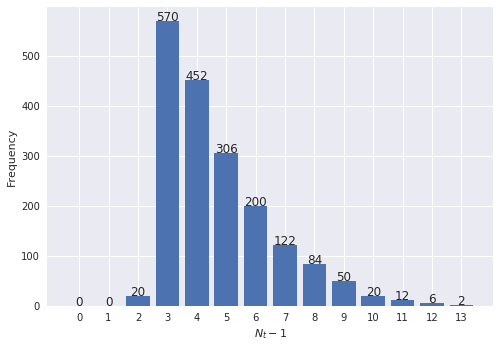

In [17]:
plt.bar([ind for ind in range(14)], length)
plt.xticks([ind for ind in range(14)])
for ind in range(14):
    plt.annotate(length[ind], xy=(ind, length[ind]+1), horizontalalignment='center')
plt.xlabel('$N_t - 1$')
plt.ylabel('Frequency')
plt.show()

In [18]:
with open("question_input.json") as f:
    inp = json.load(f)
sentence = {}
for i in inp:
    key = '%s-%s-%s-%d'%(i['constraint'], i['conversation_id'], i['action_id'], i['sentence index'])
    sentence[key] = i['content']
with open("question_features.json") as f:
    q = json.load(f)
QUESTIONS = defaultdict(list)
l = 0
for key, val in q.items():
    action = key.split('-')[2]
    new_key = key.split('-')[1]
    if not(action in last_actions):
        QUESTIONS[new_key].append(np.argmin(val['normy_cluster_dist_vector'])) 
        l += 1

In [19]:
matched_pairs = []
title_dic = defaultdict(list)
for ind, doc in enumerate(cleaned):
    conversation, clss, conv_id = doc
    title_dic[conversation['action_feature'][0]['page_title']].append(ind)
matched_pairs = list(title_dic.values())
print(len(matched_pairs))

794


In [20]:
len(feature_sets) / 2

922.0

In [21]:
def _get_question_features(conv_id, QUESTIONS):
    ret = {}
    for ind in range(8):
        ret['question_type%d'%(ind)] = 0
    if conv_id in QUESTIONS:
        for x in QUESTIONS[conv_id]:
            ret['question_type%d'%(x)] = 1
    return ret

In [22]:
documents = cleaned

In [23]:
def get_features(BOW = False, Conversational = False, User = False, ACTION_FEATURE = False, SNAPSHOT_LEN = False, Questions = False):
    feature_sets = []
    bow_features = []
    colorcodes = {}
    color_cnt = 0
    for pair in documents:
        conversation, clss, conv_id = pair
        feature_set = {}
        actions = conversation['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        actions = sorted(actions, \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))[::-1]
        feature_set.update(_get_term_features(actions, UNIGRAMS_LIST, BIGRAMS_LIST))
        for k in feature_set.keys():
            colorcodes[k] = color_cnt
        bow_features.append((copy.deepcopy(feature_set), clss))
    conv_features = []
    color_cnt += 1
    assigned = False
    for pair in documents:
        conversation, clss, conv_id = pair
        feature_set = {}
        actions = conversation['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
        actions = sorted(actions, \
                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))[::-1]
        feature_set.update(_get_last_n_action_features(actions, 1, LEXICONS, ACTION_FEATURE))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
            color_cnt += 1
        feature_set.update(_get_action_features(actions, LEXICONS))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
            color_cnt += 1          
        feature_set.update(_get_repeatition_features(actions))
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
            color_cnt += 1
        if Questions:
            feature_set.update(_get_question_features(conv_id, QUESTIONS))
            if not(assigned):
                for k in feature_set.keys():
                    if not(k in colorcodes): 
                        colorcodes[k] = color_cnt
                color_cnt += 1
        actions = actions[::-1]
        try:
            feature_set.update(_get_balance_features(actions))
        except:
            print([(a['id'], a['parent_id'], a['comment_type']) if 'parent_id' in a \
                   else (a['id'], a['comment_type'])for a in actions])
            break
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
            color_cnt += 1
            assigned = True
        if SNAPSHOT_LEN:
            feature_set['snapshot_len'] = conversation['snapshot_len']
        conv_features.append((copy.deepcopy(feature_set), clss))
    participant_features = []
    starter_attack_profiles = {0: [], 1:[]}
    non_starter_attack_profiles = {0: [], 1: []}
    all_profiles = {0: [], 1: []}
    blocks = []
    user_info = []
    assigned = False
    
    for ind, pair in enumerate(documents):
        conversation, clss, conv_id = pair
        actions = conversation['action_feature']
        start_time = min([a['timestamp_in_sec'] for a in actions])
        end_time = max([a['timestamp_in_sec'] for a in actions])
        for a in actions:
            if a['timestamp_in_sec'] == start_time:
                if 'user_text' in a:
                    starter = a['user_text']
                else:
                    starter = 'anon'
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a:
                    ender = a['user_text']
                else:
                    ender = 'anon'
        feature_set, user_infos = _user_features(conversation, user_features[conv_id], ASPECTS, STATUS)
        if not(assigned):
            for k in feature_set.keys():
                if not(k in colorcodes):
                    colorcodes[k] = color_cnt
            color_cnt += 1
            assigned = True
        p, b = attacker_profile(conversation,  user_infos, feature_set, attacker_profile_ASPECTS)
        user_info.append(user_infos)
        if starter == ender:
            starter_attack_profiles[clss].append(p)
        else:
            non_starter_attack_profiles[clss].append(p)
        all_profiles[clss].append(p)
        blocks.append(int(b))
        participant_features.append((copy.deepcopy(feature_set), clss))
    feature_sets = []

    for ind, pair in enumerate(documents):
        conversation, clss, conv_id = pair
        feature_set = {'no_comments': conversation['no_comments']}
        if BOW:
            feature_set.update(bow_features[ind][0])
        if Conversational:
            feature_set.update(conv_features[ind][0])
        if User:
            feature_set.update(participant_features[ind][0])
        feature_sets.append((feature_set, clss))
    return user_info, starter_attack_profiles, non_starter_attack_profiles, all_profiles, feature_sets, colorcodes

In [24]:
# BOW, Conversational, User, ACTION_FEATURE, SNAPSHOT_LEN

In [25]:
COLOR =["#6496cd",
"#c96338",
"#8264cb",
"#60a75c",
"#c361aa",
"#b0973f",
"#cc566c"]


In [26]:
def top_coefficients(classifier, feature_names, colorcodes, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features][::-1]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    """
    y_neg_pos = []
    y_pos_pos = []
    x_pos_pos = []
    x_neg_pos = []
    for ind in range(top_features):
        y_neg_pos.append(ind*3)
        y_pos_pos.append(ind*3)
        x_pos_pos.append(coef[top_positive_coefficients[ind]])
        x_neg_pos.append(coef[top_negative_coefficients[ind]])
    # create plot
    plt.figure(figsize=(20, 10))
    f, (ax2, ax1) = plt.subplots(1, 2, sharey=True, figsize=(20, 5))
    ax2.plot(x_neg_pos, y_neg_pos, 'ro', alpha = 0.7)

    ax1.plot(x_pos_pos, y_pos_pos, 'bo', alpha = 0.7)
  #  print(top_positive_coefficients)
    for ind in range(top_features):
      #  print(ind)
      #  print(top_positive_coefficients[ind])
        ax1.annotate(feature_names[top_positive_coefficients[ind]], xy=(x_pos_pos[ind], y_pos_pos[ind]), \
                     xytext=(x_pos_pos[ind]+0.003, y_pos_pos[ind]), \
                    color=COLOR[colorcodes[feature_names[top_negative_coefficients[ind]]]])
        ax2.annotate(feature_names[top_negative_coefficients[ind]], xy=(x_neg_pos[ind], y_neg_pos[ind]), \
                     xytext=(x_neg_pos[ind]+ 0.003, y_neg_pos[ind]), \
                     color=COLOR[colorcodes[feature_names[top_negative_coefficients[ind]]]])
    ax1.set_xlim()
    ax2.set_xlim(right=0.1)
    ax1.set_yticks([])
    ax2.set_yticks([])
    names = np.array(feature_names)
    plt.show()
    """
    names = np.array(feature_names)
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients]), \
        coef[top_positive_coefficients], coef[top_negative_coefficients]

In [27]:
from matplotlib.font_manager import FontProperties

In [28]:
def plot_top_coefficients(name_pos, name_neg, num_pos, num_neg, font_pos, font_neg, top_features=20):
    y_neg_pos = []
    y_pos_pos = []
    x_pos_pos = []
    x_neg_pos = []
    for ind in range(top_features):
        y_neg_pos.append(ind*3)
        y_pos_pos.append(ind*3)
        x_pos_pos.append(num_pos[ind])
        x_neg_pos.append(num_neg[ind])
    # create plot
    plt.figure(figsize=(20, 10))
    f, (ax2, ax1) = plt.subplots(2, 1, figsize=(8, 14))
    ax2.plot(x_neg_pos, y_neg_pos, 'ro', alpha = 0.7)

    ax1.plot(x_pos_pos, y_pos_pos, 'bo', alpha = 0.7)
  #  print(top_positive_coefficients)
    for ind in range(top_features):
      #  print(ind)
      #  print(top_positive_coefficients[ind])
        ax1.annotate(name_pos[ind], xy=(x_pos_pos[ind], y_pos_pos[ind]), \
                     xytext=(x_pos_pos[ind]+0.003, y_pos_pos[ind]), \
                    fontproperties=font_pos[ind])
        ax2.annotate(name_neg[ind], xy=(x_neg_pos[ind], y_neg_pos[ind]), \
                     xytext=(x_neg_pos[ind]+ 0.003, y_neg_pos[ind]), \
                     fontproperties=font_neg[ind])
    ax1.set_xlim(right=0.85)
    ax2.set_xlim(right=0.25)
    ax1.set_yticks([])
    ax2.set_yticks([])
    plt.show()

In [29]:
X, y, feature_names = documents2feature_vectors(feature_sets)
len_only_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.500 for {'C': 0.0001} 0.0
0.500 for {'C': 0.0002} 0.0
0.500 for {'C': 0.0005} 0.0
0.500 for {'C': 0.0007} 0.0
0.500 for {'C': 0.0009000000000000001} 0.0
0.5


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [30]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print(len(feature_sets[0][0]))
conv_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


104
Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.568 for {'C': 0.01} 0.0113362668758
0.571 for {'C': 0.02} 0.0111472310705
0.579 for {'C': 0.05} 0.010997204726
0.578 for {'C': 0.07} 0.0110635359273
0.581 for {'C': 0.09} 0.01105547213
0.580802603037


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [28]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features()
X, y, feature_names = documents2feature_vectors(feature_sets)
print(len(feature_sets[0][0]))
conv_only_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1
Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0007, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.500 for {'C': 0.0001} 0.0
0.501 for {'C': 0.00030000000000000003} 0.00276461700238
0.501 for {'C': 0.0005} 0.00276461700238
0.503 for {'C': 0.0007} 0.004514582199
0.503 for {'C': 0.0009000000000000001} 0.004514582199
0.502711496746


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [27]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print(len(feature_sets[0][0]))
conv_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


102
Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.565 for {'C': 0.01} 0.0114046922044
0.561 for {'C': 0.03} 0.0109973866912
0.569 for {'C': 0.05} 0.0109418797835
0.572 for {'C': 0.07} 0.0110459680085
0.576 for {'C': 0.09} 0.0110127105719
0.576464208243


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [29]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print(len(feature_sets[0][0]))
conv_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


106
Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.568 for {'C': 0.01} 0.0113362668758
0.576 for {'C': 0.03} 0.0109795747165
0.579 for {'C': 0.05} 0.010997204726
0.578 for {'C': 0.07} 0.0110635359273
0.581 for {'C': 0.09} 0.01105547213
0.580802603037


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [40]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
print(len(feature_sets[0][0]))
conv_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


104
Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.568 for {'C': 0.01} 0.0113362668758
0.571 for {'C': 0.02} 0.0111472310705
0.579 for {'C': 0.05} 0.010997204726
0.578 for {'C': 0.07} 0.0110635359273
0.581 for {'C': 0.09} 0.01105547213
0.580802603037


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [58]:
from sklearn.externals import joblib
joblib.dump(classifier, 'a+b_classifier.pkl')

['a+b_classifier.pkl']

In [69]:
classifier = svm.LinearSVC(C=0.09)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
coef = classifier.coef_.ravel()
for ind, f in enumerate(coef):
    if 'pron_you' in feature_names[ind]:
        print(feature_names[ind], f)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


last_1_LEXICON_pron_you 0.0
user_last_action_LEXICON_pron_you -0.0523896146728


In [67]:
classifier = svm.LinearSVC(C=0.09)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names,  colorcodes, 20)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
top_pos

['max_toxicity_gap',
 'question_type1',
 'question_type3',
 'has_question',
 'user_last_action_has_thank',
 'user_last_action_has_greetings',
 'user_last_action_has_disagree',
 'has_content_words_repeat',
 'consecutive_negative',
 'frac. negative_reply',
 'max_nouns_over_tokens',
 'question_type0',
 'max_len',
 'min_len',
 'avg_len',
 'question_type4',
 'max_polarity_gap',
 'min_nouns_over_tokens',
 'max_time_gap',
 'toxicity_entropy']

In [46]:
len(top_neg)

20

In [47]:
Normal = FontProperties()
Italic = Normal.copy()
Italic.set_style('italic')
Bold = Normal.copy()
Bold.set_weight('bold')

font_pos = []
for ind in range(20):
    font_pos.append(Normal)
font_neg = []
for ind in range(20):
    font_neg.append(Normal)

In [69]:
top_pos = ['Toxicity entropy', 
'Reply time (max)',
'Personal noun diversity (min)',
'Personal polarity gap (max)',
'Question type: Call for Feedback',
'Comment length (average)',
'Comment length (min)',
'Comment length (max)',
'Question type: Informational Queries',
'Personal noun diversity (max)',
'% negative polarity replies',
'Personal consecutive negative',
'Personal repeat content (binary)',
'Disagreement (participant)',
'Politeness greetings (participant)',
'Politeness gratitude (participant)',
'Has questions',
'Question type: Clarification requests',
'Question type: Polite Requests',
'Toxicity gap (max)'][::-1]

In [70]:
font_pos = [Italic, 
            Bold, 
            Italic, 
            Italic, 
            Normal, 
            Normal, 
            Normal, 
            Normal, 
            Normal, 
            Italic, 
            Italic, 
            Italic, 
            Italic, 
            Normal, Normal, Normal, Normal, Normal, Normal, Normal]

In [76]:
top_neg = ['Toxicity (max)', 
'Toxicity gap (mean)', 
'Noun Type-to-Token (overall)', 
'Uses \'?!\'', 
'Reply polarity', 
'Personal polarity increase', 
'Question reply', 
'Positive reply to negative', 
'Stopword adoption rate',
'Question type: Aggressive Interrogatives',
'Start with \'do\'/\'don\'t\'',
'Personal language consistency', 
'Starts with verb',
'Longest thread',
'Adoption of content words',
'Reciprocity',
'Negative reply to positive', 
'Reply time (entropy)',
'Replies received (entropy)',
'Polarity gap (overall)'][::-1]

In [88]:
font_neg = [Normal,
            Normal,
            Bold,
            Normal, 
            Italic,
            Italic,
            Bold,
            Italic,
            Normal,
            Normal,
            Normal,
            Normal,
            Normal,
            Bold,
            Italic,
            Bold,
            Italic,
            Bold,
            Bold,
            Italic]

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


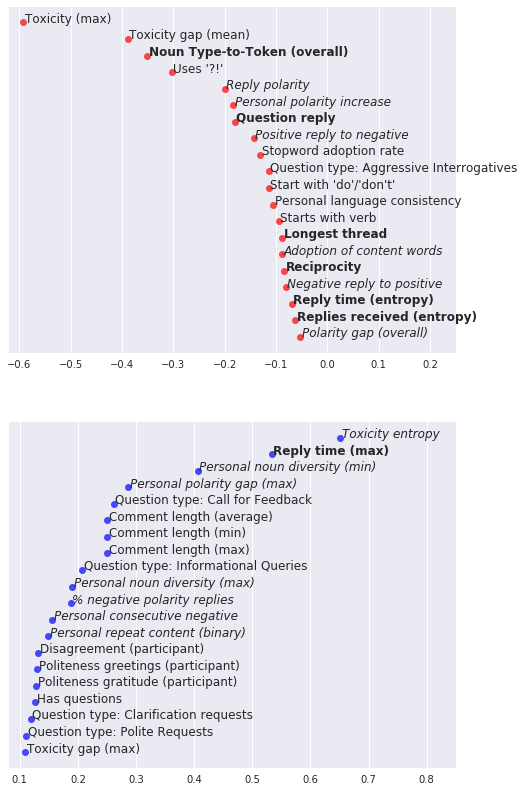

In [89]:

plot_top_coefficients(top_pos, top_neg, num_pos, num_neg, font_pos[::-1], font_neg[::-1])

In [35]:
classifier = svm.LinearSVC(C=0.09)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True, User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [41]:
print('\n'.join(feature_names))

action_no_entropy
age_entropy
age_gap
age_variance
avg_len
bot_modification
comments_on_all_talk_pages_entropy
comments_on_all_talk_pages_gap
comments_on_all_talk_pages_variance
comments_on_same_talk_page_entropy
comments_on_same_talk_page_gap
comments_on_same_talk_page_variance
consecutive_negative
content_words_adoption
content_words_repeat
conversation_polarity_gap
edits_on_subjectpage_entropy
edits_on_subjectpage_gap
edits_on_subjectpage_variance
edits_on_wikipedia_articles_entropy
edits_on_wikipedia_articles_gap
edits_on_wikipedia_articles_variance
frac. negative_reply
has_anon
has_bot
has_content_words_adoption
has_content_words_repeat
has_deletion
has_modification
has_negative_reply
has_policy_intervention
has_pos_bigrams_repeat
has_question
has_restoration
has_stopwords_adoption
has_stopwords_repeat
history_toxicity_entropy
history_toxicity_gap
history_toxicity_variance
interaction_density
last_1_LEXICON_negative
last_1_LEXICON_positive
last_1_LEXICON_pron_3rd
last_1_LEXICON_pr

In [36]:
classifier = svm.LinearSVC(C=0.09)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names, colorcodes, 20)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
print('\n'.join(top_neg[::-1]))

max_toxicity
mean_toxicity_gap
nouns_over_tokens
user_last_action_has_consecutive_?or!
has_negative_reply
positive_increase
question_to_non_question
positive reply to negative
nouns_over_tokens_entropy
question_type5
user_last_action_do/don't start
stopwords_adoption
content_words_repeat
user_last_action_verb start
reciprocity
max_depth
time_gap_entropy
negative reply to positive
content_words_adoption
has_stopwords_repeat


In [27]:
classifier = svm.LinearSVC(C=0.09)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names, colorcodes, 20)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [56]:
print('\n'.join(top_pos[::-1]))

toxicity_entropy
max_time_gap
min_nouns_over_tokens
max_polarity_gap
question_type4
min_len
max_len
avg_len
question_type0
frac. negative_reply
max_nouns_over_tokens
consecutive_negative
has_content_words_repeat
user_last_action_has_disagree
user_last_action_has_greetings
user_last_action_has_thank
has_question
question_type3
max_toxicity_gap
question_type1


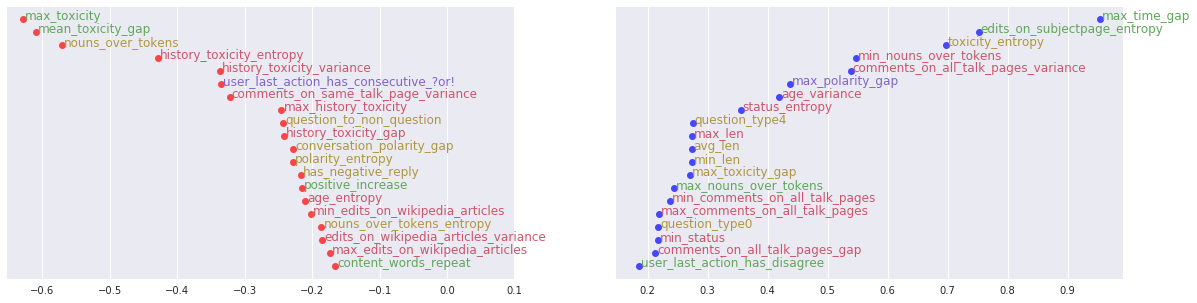

In [67]:
classifier = svm.LinearSVC(C=0.5)
#user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True)
#X, y, feature_names = documents2feature_vectors(feature_sets)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, pos_num, neg_num = top_coefficients(classifier, feature_names, colorcodes, 20)

In [29]:
Normal = FontProperties()
Italic = Normal.copy()
Italic.set_style('italic')
Bold = Normal.copy()
Bold.set_weight('bold')

font_pos = []
for ind in range(15):
    font_pos.append(Normal)
font_neg = []
for ind in range(15):
    font_neg.append(Normal)

In [30]:
classifier = svm.LinearSVC(C=0.09)
#user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True)
#X, y, feature_names = documents2feature_vectors(feature_sets)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
classifier.fit(X, y)
top_pos, top_neg, num_pos, num_neg = top_coefficients(classifier, feature_names, colorcodes, 15)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
len(feature_names)

31

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


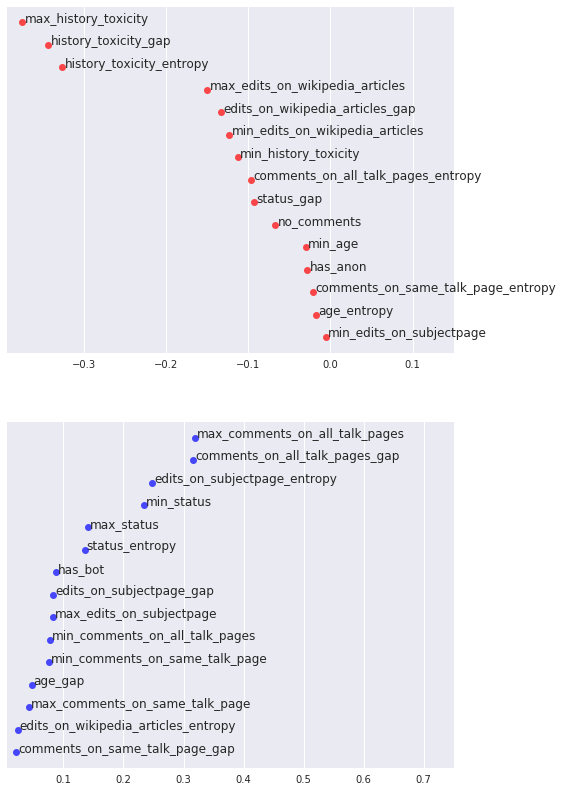

In [32]:
plot_top_coefficients(top_pos, top_neg, num_pos, num_neg, font_pos, font_neg, 15)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


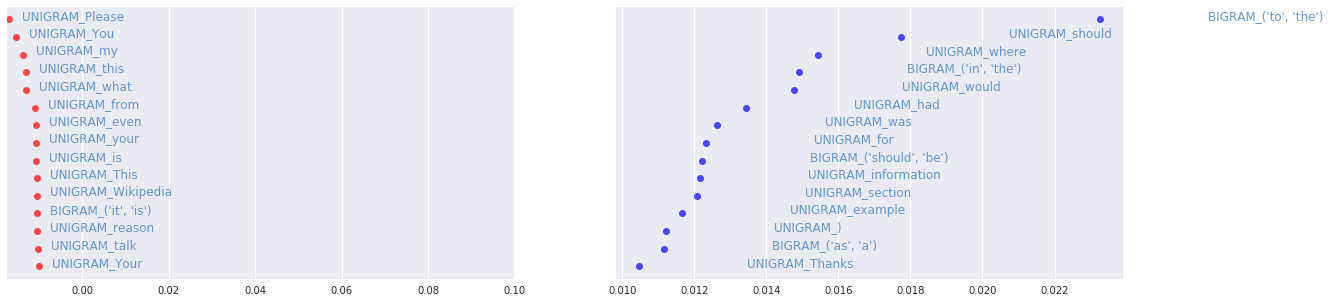

In [54]:
classifier = svm.LinearSVC(C=0.0002)
#user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True)
#X, y, feature_names = documents2feature_vectors(feature_sets)
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)

classifier.fit(X, y)
top_pos, top_neg, pos_num, neg_num = top_coefficients(classifier, feature_names, colorcodes, 15)

In [70]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(BOW=True, Conversational=True, User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
full_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0002, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.565 for {'C': 0.0002} [ 0.53859677  0.58206077]
0.551 for {'C': 0.0005} [ 0.52676322  0.57066016]
0.551 for {'C': 0.0008} [ 0.52697313  0.5719852 ]
0.553 for {'C': 0.0009000000000000001} [ 0.52807515  0.57291667]
0.56453362256


In [31]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
bow_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0002, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.555 for {'C': 0.0001} 0.0107790925861
0.560 for {'C': 0.0002} 0.0112738322257
0.547 for {'C': 0.0005} 0.0114452034134
0.547 for {'C': 0.0007} 0.0114865905067
0.547 for {'C': 0.0009000000000000001} 0.0117229221541
0.560195227766


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [29]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(BOW=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
bow_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.555 for {'C': 0.0001} 0.0107790925861
0.554 for {'C': 0.00030000000000000003} 0.0113801125862
0.547 for {'C': 0.0005} 0.0114452034134
0.547 for {'C': 0.0007} 0.0114865905067
0.547 for {'C': 0.0009000000000000001} 0.0117229221541
0.555314533623


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [64]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [66]:
lst = [[], []]
for f in feature_sets:
    ff, clss = f
    lst[clss].append(ff['status_entropy'])

In [67]:
scipy.stats.wilcoxon(lst[0], lst[1])

WilcoxonResult(statistic=111684.0, pvalue=0.46378292144856681)

In [28]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
user_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.07, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.527 for {'C': 0.01} 0.00946433585366
0.527 for {'C': 0.03} 0.00951723586425
0.528 for {'C': 0.05} 0.00950603579897
0.531 for {'C': 0.07} 0.00950815957673
0.531 for {'C': 0.09} 0.00955860940792
0.531453362256


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [31]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
user_only_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.527 for {'C': 0.01} 0.00946803295514
0.526 for {'C': 0.03} 0.00943806891812
0.531 for {'C': 0.05} 0.00951729716423
0.535 for {'C': 0.07} 0.0095495735231
0.535 for {'C': 0.09} 0.00957472582476
0.535249457701


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [34]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, all_profiles, feature_sets, colorcodes = get_features(User=True, Conversational=True, Questions=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
user_conv_scores = train_svm(X, y, 0.01, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.02, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.580 for {'C': 0.02} 0.0221276730861
0.577 for {'C': 0.05} 0.0224530979952
0.578 for {'C': 0.08} 0.0223609820894
0.577 for {'C': 0.09} 0.0224398753584
0.580260303688


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [26]:
user_info, starter_attack_profiles, non_starter_attacker_profiles, feature_sets, colorcodes = get_features(BOW=True, Conversational=True)
X, y, feature_names = documents2feature_vectors(feature_sets)
bow_conv_scores = train_svm(X, y, 0.0001, 0.001, matched_pairs)

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fitting
794 794
Best parameters set found on development set:

LinearSVC(C=0.0002, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:



/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


0.563 for {'C': 0.0002} [ 0.53741604  0.58063077]
0.556 for {'C': 0.0005} [ 0.53093514  0.57535684]
0.553 for {'C': 0.0008} [ 0.52857368  0.57256245]
0.562906724512


In [28]:
scipy.stats.wilcoxon(user_conv_scores, bow_scores)

WilcoxonResult(statistic=42016.5, pvalue=0.049301625932508066)

In [46]:
scipy.stats.wilcoxon(user_conv_scores, user_only_scores)

WilcoxonResult(statistic=35372.5, pvalue=0.0004427204341318081)

In [33]:
scipy.stats.wilcoxon(user_only_scores, conv_only_scores)

WilcoxonResult(statistic=41778.5, pvalue=0.0011485765170018494)

In [32]:
scipy.stats.wilcoxon(bow_scores, conv_only_scores)

WilcoxonResult(statistic=43927.5, pvalue=0.066638840571656408)

In [43]:
with open('human.json') as f:
    human_scores = json.load(f)

In [44]:
scipy.stats.wilcoxon(human_scores, conv_only_scores)

WilcoxonResult(statistic=95204.5, pvalue=0.75042176333870081)

In [45]:
with open('human_p.json') as f:
    human_p = json.load(f)

In [46]:
scipy.stats.mannwhitneyu(human_p, conv_only_scores)

MannwhitneyuResult(statistic=135538.5, pvalue=0.16240752833839084)

In [35]:
scipy.stats.wilcoxon(human_p, conv_only_scores)

WilcoxonResult(statistic=96355.5, pvalue=0.53433186263271271)

In [35]:
scipy.stats.wilcoxon(human_p, user_conv_scores)

WilcoxonResult(statistic=61109.5, pvalue=0.29931464992582801)

# Ploting Utilities

In [123]:
def plot_profiles1(profiles, ASPECTS, experience=-1):
    catergories = {'Min': 0, 'Max': 1, 'In the Middle': 2, 'Anonymous':3, 'New Comer':4, 'No Gap': 5, 'Bot': 6}
    cats = ['min', 'max', 'in the middle', 'Anonymous', 'New Comer']

    f, ax = plt.subplots(1, figsize=(13,6))
    bar_width = 0.4
    bar_l = [i for i in range(len(ASPECTS))] 
    tick_pos = [i+bar_width for i in bar_l]

    colors = ['pink', 'mediumslateblue', 'steelblue', 'mediumaquamarine', 'darksalmon']
    bads = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    total = len(profiles[0])
    alpha=[0.9, 0.3]
    conv_label = ['Offender is ', 'Non-offender is ']
    mins = [[], []]
    cnts = [[[], [], [], [], [], [], []], [[], [], [], [], [], [], []]]
    rects = []
    for clss in [0, 1]:
        for aspect in ASPECTS:
            cur = []
            for ind in range(len(catergories)):
                bads[clss][ind].append(0)
                cnts[clss][ind].append(0)
            for p in profiles[clss]:
            #    if not('experience') in p or p['experience'] <= experience:
            #        continue
                bads[clss][catergories[p[aspect]]][-1] += 1
                cnts[clss][catergories[p[aspect]]][-1] += 1
                if catergories[p[aspect]] == 0:
                    cur.append(1)
                elif catergories[p[aspect]] < 3:
                    cur.append(0)
            mins[clss].append(cur)
        previous = [0 for a in ASPECTS]
        first_three = [0 for a in ASPECTS]
        for bad in bads[clss][:3]:
            for ii, b in enumerate(bad):
                first_three[ii] += b
        for ind,bad in enumerate(bads[clss][:3]):
            for ii, b in enumerate(bad):
                if first_three[ii]: bad[ii] = bad[ii] / first_three[ii]
            bads[clss][ind] = bad
            rects = ax.bar(bar_l, bad, label=conv_label[clss] + cats[ind], bottom = previous, alpha=alpha[clss], \
                color=colors[ind],width=bar_width,edgecolor='white')
            for ind, rect in enumerate(rects):
                ax.text(rect.get_x() + rect.get_width()/2., (bad[ind] / 3 + previous[ind]),
                '%.1f' % (bad[ind]*100) + '%',
                ha='center', va='bottom')
            for ii, b in enumerate(bad):
                previous[ii] += b
      #  ax.legend(loc="upper center", bbox_to_anchor=(1,1), fontsize='large')
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0., fontsize='large')
        bar_l = [b+bar_width for b in bar_l]
        if clss:
            print('Good Total:')
        else:
            print('Bad Total:')
        for ii,aspect in enumerate(ASPECTS):
            print(aspect, first_three[ii])
    ax.set_ylabel("Percentage among All the Cases", fontsize='large')
  #  ax.set_xlabel("Aspect")
    Xticks = ['Proportion replied',\
              'Being replied latency', 'Reply latency', \
            'Age', 'Status', \
            '# edits on Wikipedia']
    plt.xticks([t - bar_width / 2 for t in tick_pos], Xticks, fontsize='large')
  #  ax.set_xlabel("")

    # rotate axis labels
    plt.setp(plt.gca().get_xticklabels(), rotation=20, horizontalalignment='right')
   # plt.title('Who\'s the Attacker')

    # shot plot
    plt.show()
  #  for aspect in ASPECTS:
  #      print(aspect, first_three[0], first_three[1])

    print('Test 1')
    for ind, aspect in enumerate(ASPECTS):
        print(aspect)
        print('Average in Ggap: ', np.mean(mins[1][ind]))
        print('Average of Bgap: ', np.mean(mins[0][ind]))
        if np.mean(mins[1][ind]) == 1 or np.mean(mins[1][ind]) == 0:
            continue
        print(scipy.stats.mannwhitneyu(mins[0][ind], mins[1][ind]))
        print('\n')
    print('Test 2')
    clss = 0
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
     #   print(cnts[clss][0][ind], cnts[clss][1][ind])
    print('\n')
    print('Test 3')
    clss = 1
    for ind, aspect in enumerate(ASPECTS):
        print(aspect, ':', scipy.stats.binom_test(cnts[clss][0][ind], cnts[clss][0][ind] + cnts[clss][1][ind]))
    

In [124]:
plot_attacker_profile_ASPECTS = ['proportion_of_being_replied',\
                                 'total_reply_time_gap', 'reply_latency',\
                                'age', 'status', \
                                'edits_on_wikipedia_articles']

Bad Total:
proportion_of_being_replied 813
total_reply_time_gap 777
reply_latency 816
age 756
status 502
edits_on_wikipedia_articles 743
Good Total:
proportion_of_being_replied 849
total_reply_time_gap 802
reply_latency 847
age 814
status 537
edits_on_wikipedia_articles 765


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


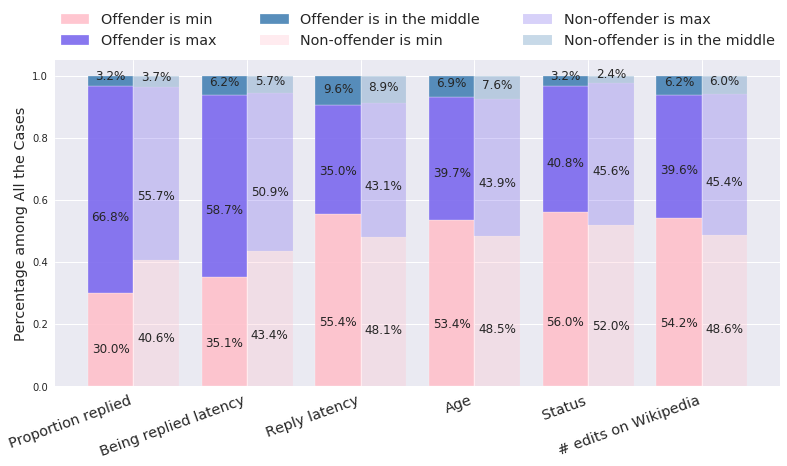

Test 1
proportion_of_being_replied
Average in Ggap:  0.406360424028
Average of Bgap:  0.30012300123
MannwhitneyuResult(statistic=308454.0, pvalue=3.0228344948628823e-06)


total_reply_time_gap
Average in Ggap:  0.43391521197
Average of Bgap:  0.351351351351
MannwhitneyuResult(statistic=285852.0, pvalue=0.00039448518824339405)


reply_latency
Average in Ggap:  0.480519480519
Average of Bgap:  0.553921568627
MannwhitneyuResult(statistic=320210.0, pvalue=0.001379041134200536)


age
Average in Ggap:  0.485257985258
Average of Bgap:  0.534391534392
MannwhitneyuResult(statistic=292574.0, pvalue=0.02587990043698123)


status
Average in Ggap:  0.519553072626
Average of Bgap:  0.559760956175
MannwhitneyuResult(statistic=129367.5, pvalue=0.097055171073138713)


edits_on_wikipedia_articles
Average in Ggap:  0.486274509804
Average of Bgap:  0.542395693136
MannwhitneyuResult(statistic=268248.0, pvalue=0.014659333527836651)


Test 2
proportion_of_being_replied : 5.59188466373e-27
total_reply_time_ga

In [125]:
plot_profiles1(all_profiles, plot_attacker_profile_ASPECTS)

Bad Total:
proportion_of_being_replied 410
total_reply_time_gap 389
reply_latency 409
age 383
status 238
edits_on_wikipedia_articles 369
Good Total:
proportion_of_being_replied 386
total_reply_time_gap 364
reply_latency 385
age 376
status 232
edits_on_wikipedia_articles 349


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


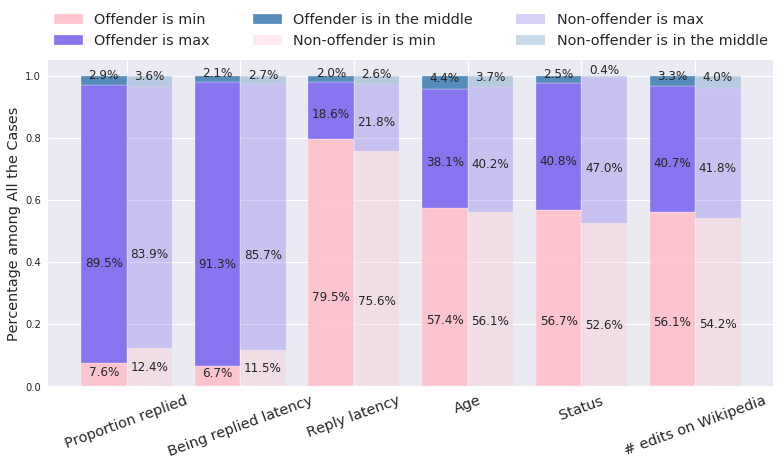

Test 1
proportion_of_being_replied
Average in Ggap:  0.124352331606
Average of Bgap:  0.0756097560976
MannwhitneyuResult(statistic=75273.0, pvalue=0.01081131654485918)


total_reply_time_gap
Average in Ggap:  0.115384615385
Average of Bgap:  0.0668380462725
MannwhitneyuResult(statistic=67361.0, pvalue=0.010149929207465559)


reply_latency
Average in Ggap:  0.755844155844
Average of Bgap:  0.794621026895
MannwhitneyuResult(statistic=75679.5, pvalue=0.095374274618091004)


age
Average in Ggap:  0.561170212766
Average of Bgap:  0.574412532637
MannwhitneyuResult(statistic=71050.5, pvalue=0.35651847601634024)


status
Average in Ggap:  0.525862068966
Average of Bgap:  0.567226890756
MannwhitneyuResult(statistic=26466.0, pvalue=0.1842470473592277)


edits_on_wikipedia_articles
Average in Ggap:  0.541547277937
Average of Bgap:  0.560975609756
MannwhitneyuResult(statistic=63139.5, pvalue=0.30062529893461332)


Test 2
proportion_of_being_replied : 4.89383860096e-74
total_reply_time_gap : 5.7655

In [121]:
plot_profiles1(starter_attack_profiles, plot_attacker_profile_ASPECTS)

Bad Total:
proportion_of_being_replied 403
total_reply_time_gap 388
reply_latency 407
age 373
status 264
edits_on_wikipedia_articles 374
Good Total:
proportion_of_being_replied 463
total_reply_time_gap 438
reply_latency 462
age 438
status 305
edits_on_wikipedia_articles 416


/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


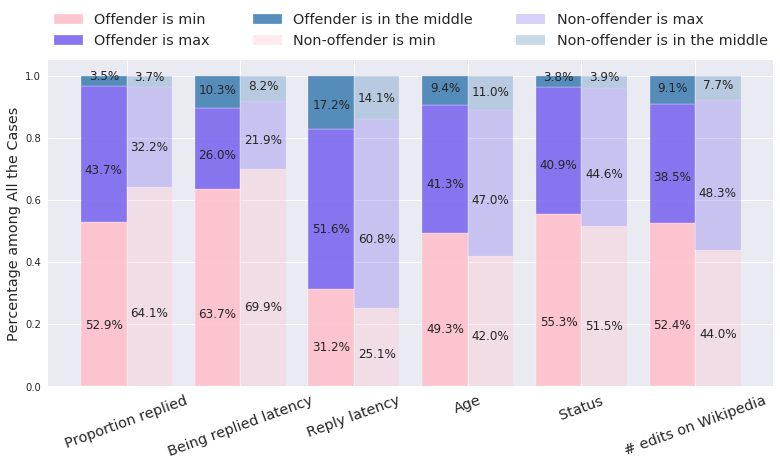

Test 1
proportion_of_being_replied
Average in Ggap:  0.641468682505
Average of Bgap:  0.528535980149
MannwhitneyuResult(statistic=82758.5, pvalue=0.00037998571394252077)


total_reply_time_gap
Average in Ggap:  0.698630136986
Average of Bgap:  0.636597938144
MannwhitneyuResult(statistic=79701.0, pvalue=0.029364380162119896)


reply_latency
Average in Ggap:  0.251082251082
Average of Bgap:  0.312039312039
MannwhitneyuResult(statistic=88286.0, pvalue=0.022938621951742073)


age
Average in Ggap:  0.420091324201
Average of Bgap:  0.493297587131
MannwhitneyuResult(statistic=75707.0, pvalue=0.018509805576858308)


status
Average in Ggap:  0.514754098361
Average of Bgap:  0.55303030303
MannwhitneyuResult(statistic=38719.0, pvalue=0.18101865807177686)


edits_on_wikipedia_articles
Average in Ggap:  0.439903846154
Average of Bgap:  0.524064171123
MannwhitneyuResult(statistic=71245.0, pvalue=0.0090783526803408301)


Test 2
proportion_of_being_replied : 0.0678222573185
total_reply_time_gap : 2.99

In [122]:
plot_profiles1(non_starter_attacker_profiles, plot_attacker_profile_ASPECTS)

In [40]:
plot_profiles1(starter_attacker_profiles, attacker_profile_ASPECTS)

NameError: name 'starter_attacker_profiles' is not defined

In [25]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

In [47]:
def plot_feature_distribution(all_features, features):
    cnts = {}
    for f in features:
        cnts[f] = {0:[], 1:[]}

    for pair in all_features:
        fea, clss = pair
        for f in fea.keys():
            if f in features:
                cnts[f][clss].append(fea[f])
    
    print('finish collecting')
    means_0 = []
    means_1 = []
    stds_0 = []
    stds_1 = []
    for f in features:
        means_0.append(np.mean(cnts[f][0]))
        means_1.append(np.mean(cnts[f][1]))
        stds_0.append(np.std(cnts[f][0]))
        stds_1.append(np.std(cnts[f][1]))
    
    
    N = len(features)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    plt.figure(figsize=(15, 5))
    rects1 = plt.bar(ind, means_0, width, color='r', yerr=stds_0)

    rects2 = plt.bar(ind + width, means_1, width, color='y', yerr=stds_1)

    # add some text for labels, title and axes ticks
  #  plt.set_ylabel('Average')
    plt.title('Predictive Features by group')
    plt.xticks(ind + width / 2, features, rotation=60, ha='right')
 #   plt.set_xticklabels(features)

    plt.legend((rects1[0], rects2[0]), ('Bad Conversation', 'Good Conversations'))

    plt.show()

In [102]:
def get_examples(documents, pairs, the_feature, the_value, number, wanted_class, answer, profiles, wanted_id, top_pos, top_neg):
    conversations = {}
    for ind, doc in enumerate(documents):
        conversation, clss, conv_id = doc
        conversations[conv_id] = ind
    cnt = 0
    acc = 0
    for ind, pair in enumerate(pairs):
        fea, clss = pair
        conversation, clss, conv_id = documents[ind]
        if clss:
            matched_id = conversation['action_feature'][0]['bad_conversation_id']
        else:
            matched_id = conversation['action_feature'][0]['good_conversation_id']
        the_match = conversations[matched_id]
        f = the_feature
     #   if documents[ind][2] == wanted_id:
    #    if fea[f] >= the_value and clss == wanted_class and \
    #        pairs[the_match][0][f] < the_value and answer[ind] == clss and \
    #        answer[the_match] == 1 - clss:
        if clss == wanted_class and answer[ind] == clss and \
            answer[the_match] == 1 - clss and not('user' in conversation['action_feature'][0]['page_title'].lower()):
            number -= 1
            ls = []
            for ii in [ind, the_match]:
                conv_id = documents[ii][2]
                actions = sorted(documents[ii][0]['action_feature'], \
                                key=lambda k: (k['timestamp_in_sec'], k['id'].split('.')[1], k['id'].split('.')[2]))
                end_time = max([a['timestamp_in_sec'] for a in actions])
            #    actions = [a for a in actions if a['timestamp_in_sec'] < end_time]
                snapshot = generate_snapshots(actions)
                ls.append(len(snapshot))
                the_action = {}
                for a in actions:
                    the_action[a['id']] = a
           #     print([(a['content'], a['user_text'], a['id'], a['comment_type']) for a in actions])
                if number == 0:
                    print(actions[0]['conversation_id'])
                #    print(pairs[ii][0][f])
                #    print('positives')
                #    for ff in top_pos[::-1]:
                #        print(ff, pairs[ii][0][ff])
                #    print('negatives')
                #    for ff in top_neg:
                #        print(ff, pairs[ii][0][ff])
                    for s in snapshot:
                        #  print(the_action[s['id']]['content_words'])
                        print(s['content'])
                        print(s['user_text'], profiles[ii][s['user_text']])
                        print(s['relative_replyTo'])
                    #      print(the_action[s['id']]['pron_you'])
                    print('\n')
            if (ls[0] - ls[1] <= 1) and (ls[0] - ls[1] >= -1):
                cnt += 2
                acc += (answer[ind] == clss)
                acc += (answer[the_match] == 1 - clss)
            if number == 0:
                return
 #   print(cnt, acc / cnt)

In [216]:
classifier = linear_model.LogisticRegression(C=0.007)
classifier.fit(X, y)
ans = classifier.predict(X)
get_examples(documents, feature_sets, 'user_last_action_has_polite', 1,1, 0, ans, user_info, '166342666.20.23', top_pos, top_neg)

157597403.0.0
 ==uncover==
74.192.20.87 {'proportion_of_being_replied': 0.5, 'proportion_of_utterance_over_all': 0.5, 'total_length_of_utterance': 60, 'maximum_toxicity': 0.12057688943610838, 'self_modification': 0.0, 'other_modification': 0.0, 'pron_you_usage': 1, 'gratitude_usage': 0, 'max_negativity': 0, 'anon': 1, 'age': 0, 'status': 0, 'comments_on_same_talk_page': 3, 'comments_on_all_talk_pages': 20, 'edits_on_subjectpage': 0, 'edits_on_wikipedia_articles': 217}
-1
are there any old ags on here who can verify that "uncovering" is a tradition? and by old ags i mean at least going back to the 70's. im pretty sure that uncovering is reserved for the national anthem, prayer, and if you are a true texan, texas our texas.   —Preceding [Wikipedia:Signatures@unsigned] comment added by 
74.192.20.87 {'proportion_of_being_replied': 0.5, 'proportion_of_utterance_over_all': 0.5, 'total_length_of_utterance': 60, 'maximum_toxicity': 0.12057688943610838, 'self_modification': 0.0, 'other_modific

In [188]:
###### classifier = linear_model.LogisticRegression(C=0.007)
classifier.fit(X, y)
ans = classifier.predict(X)
#get_examples(documents, feature_sets, 'has_content_repeat', 1, 3, 1, ans)
get_examples(documents, feature_sets, 'user_last_action_has_polite', 1,23, 1, ans)

93622588.1469.1469
1
 ==References==
65.118.187.102
-1
 I'm removing unverified/unreferenced stuff from this article. Too bad that's nearly all of it. Try to reference all of this [WP:NOR@original research].
65.118.187.102
0
 :It is easier to get things referenced by leaving a tag on the page as opposed to almost blanking it. I'm going to restore it with a verifiability tag.  [Wikipedia:Editor review/The Hybrid@R]
The Hybrid
1
Someone want to explain to me how a professional wrestling slang term needs an "original research" tag? This whole event is ridiculous. It's like what happened to the [Vic Grimes] article where someone kept tagging every line in the article with "citation needed." This article has been around for 2 years, so why is it that NOW, because one person, who's not only on a school IP address, but is also acting completely childish by blanking the page (which is clearly [WP:VAND#Types_of_vandalism@blatant vandalism]) has the right to suddenly say "this article needs orig

In [55]:
def get_tile(num, tiles):
    for ind, t in enumerate(tiles):
        if num <= t:
            return ind

In [56]:
def get_values(aspect, feature_sets):
    values = []
    for pair in feature_sets:
        f, clss = pair
        values.append(f['min_%s'%(aspect)])
        values.append(f['max_%s'%(aspect)])
    values = np.array(values)
    return values

In [57]:
def discrepancy_heatmap_total(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        data[mini][maxi] += clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1]:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    sns.heatmap(total_d[::-1], annot=True)
    #sns.heatmap(data[::-1], annot=True)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()

In [32]:
aspect = 'age'
convs = {}
deleted = {}
good = []
bad = []
good_ages = []
bad_ages = []
EPS = 0
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    action = conversation['action_feature'][0]
    if False: #f['min_%s'%aspect] >= 6 or f['has_anon'] == 1:
        deleted[conv_id] = 1
        if clss:
            deleted[action['bad_conversation_id']] = 1
        else:
            deleted[action['good_conversation_id']] = 1   
print(len(deleted))
for ind, pair in enumerate(feature_sets):
# No anonymous in the conversation
    f, clss = pair
    conversation, clss, conv_id = documents[ind]
    if conv_id in deleted:
        continue
    mini = f['min_%s'%aspect]
    if mini < 6:
        if clss:
            good.append(f['max_%s'%aspect] - mini)
        else:
            bad.append(f['max_%s'%aspect] - mini)
  #  for user in user_info[ind].keys():
  #      if clss and 'age' in user_info[ind][user]:
  #          good_ages.append(user_info[ind][user][aspect])
  #      else:
  #          bad_ages.append(user_info[ind][user][aspect])

0


In [33]:
# average age

In [34]:
print(len(good), len(bad))

257 283


In [35]:
print(np.mean(good), np.mean(bad), scipy.stats.mannwhitneyu(good, bad))
print(np.mean(good_ages), np.mean(bad_ages), scipy.stats.mannwhitneyu(good_ages, bad_ages))

33.029664532 27.2448653727 MannwhitneyuResult(statistic=31642.0, pvalue=0.0045156875387029087)
nan nan MannwhitneyuResult(statistic=0.0, pvalue=0.0)


/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yiqing/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [71]:
gaplst = []
labellst = []
for pair in feature_sets:
    f, clss = pair
    gaplst.append(f['history_toxicity_entropy'])#'min_%s'%aspect])
    labellst.append(clss)

In [72]:
pearsonr(gaplst, labellst)

(0.10690776333325319, 2.0015048412524615e-06)

In [38]:
goods = []
bads = []
for doc in documents:
    conversation, clss, conv_id = doc
    actions = conversation['action_feature']
    start_time = min([a['timestamp_in_sec'] for a in actions])
    end_time = max([a['timestamp_in_sec'] for a in actions])
    for a in actions:
        if a['timestamp_in_sec'] == start_time:
            if 'user_text' in a:
                starter = a['user_text']
            else:
                starter = 'anon'
        if a['timestamp_in_sec'] == end_time:
            if 'user_text' in a:
                ender = a['user_text']
            else:
                ender = 'anon'
    if clss:
        goods.append(int(starter == ender))
    else:
        bads.append(int(starter == ender))
print(np.mean(goods), np.mean(bads),scipy.stats.wilcoxon(goods, bads))

0.395325203252 0.512195121951 WilcoxonResult(statistic=49335.0, pvalue=3.0972230185431e-07)


In [39]:
def discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    gaps = defaultdict(list)
    gaplst = []
    labellst = []
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
        cur_gap =  f['max_%s'%aspect] - f['min_%s'%aspect]
        if True: #f['min_%s'%aspect] < 10:
            gaplst.append(f['status_entropy'])#'min_%s'%aspect])
            labellst.append(1-clss)
        # age
  #      if cur_gap < 1:
  #          log_val = 0
  #      if cur_gap < 5:
  #          log_val = 5
  #      elif cur_gap < 10:
  #          log_val = 10
  #      elif cur_gap < 50:
  #          log_val = 50
  #      else: log_val = 150
    # edits
        if cur_gap > 0:
            log_val = int(math.log(cur_gap) / math.log(10))
            if log_val == 1:
                log_val = 2
            if log_val == 6:
                log_val = 5
        else:
            log_val = 0
        gaps[log_val].append(1-clss)
   #     print(mini,maxi, tiles)

        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data, gaps, gaplst, labellst

In [40]:
def discrepancy_heatmap_status(aspect, feature_sets, tiles, tile_legends, no_anon=False):
    total_d = []
    data = []
    total_t = len(tiles)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
    normal_vs_normal = []
    normal_vs_all_admins = []
    normal_vs_page_admins = []
    for pair in feature_sets:
        f, clss = pair
        mini = get_tile(f['min_%s'%aspect], tiles)
        maxi = get_tile(f['max_%s'%aspect], tiles)
   #     print(mini,maxi, tiles)
        if mini == 1 and maxi == 1:
            normal_vs_normal.append(1-clss)
        if mini == 1 and maxi > 1:
            normal_vs_all_admins.append(1-clss)
        data[mini][maxi] += 1-clss
        total_d[mini][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    plt.figure(figsize=(10, 8))
    #sns.heatmap(total_d[::-1], annot=True)
    mask=np.isnan(data[::-1])
    sns.heatmap(data[::-1], annot=True, mask=mask)
    plt.ylabel('Min')
    plt.xlabel('Max')
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    plt.xticks([v + 0.75 for v in range(total_t)], tile_legends, rotation=60)
    plt.show()
    return data, normal_vs_normal, normal_vs_all_admins

In [41]:
# propencity of attacking
def propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, the_bin):
    data = []
    total_d = []
    total_t = len(tiles)
    the_attacker = []
    attacker_gap = defaultdict(list)
    for v in range(total_t):
        cur = []
        cur_d = []
        for v1 in range(total_t):
            cur.append(0)
            cur_d.append(0)
        data.append(cur)
        total_d.append(cur_d)
        the_attacker.append([])
    for ind, pair in enumerate(documents):
        f, clss, conv_id = pair
        actions = f['action_feature']
        end_time = max([a['timestamp_in_sec'] for a in actions])
        attacker = None
        for a in actions:
            if a['timestamp_in_sec'] == end_time:
                if 'user_text' in a:
                    if aspect in user_info[ind][a['user_text']]:
                        last = user_info[ind][a['user_text']][aspect]
                        attacker = a['user_text']
                    else:
                        if 'bot' in user_info:
                            last = 'bot'
                        else:
                            last = None
                else:
                    last = None
                break
        maxi = 0
        avg = []
        for a in actions:
            if a['timestamp_in_sec'] < end_time and 'user_text' in a \
               and not(a['user_text'] == attacker) and aspect in user_info[ind][a['user_text']]:
                maxi = max(maxi, user_info[ind][a['user_text']][aspect])
                avg.append(user_info[ind][a['user_text']][aspect])
        if last == None or isinstance(last, str):
            last_val = 0
        else:
            last_val = last
        avg = np.median(avg)
      #  if feature_sets[ind][0]['max_%s'%(aspect)] < last_val:
      #      print(last, feature_sets[ind][0]['max_%s'%(aspect)], clss, conv_id, 'bot' in user_info[ind][attacker])
        the_gap = avg - last_val
        if the_gap > the_bin[1]:
            the_gap = 2
        elif the_gap > the_bin[0]:
            the_gap = 1
        elif the_gap <= the_bin[0] and the_gap >= -the_bin[0]:
            the_gap = 0
        elif the_gap < -the_bin[0] and the_gap >= -the_bin[1]:
            the_gap = -1
        else: the_gap = -2
        attacker_gap[the_gap].append(1-clss)
        if last == None or isinstance(last, str): 
            global_rank = 0
          #  if  last == 'bot':
            local_rank = 4
        else:
            global_rank = get_tile(last, tiles)
            vals = []
            appeared = False
            for a in actions:
                if a['timestamp_in_sec'] < end_time and 'user_text' in a and aspect in user_info[ind][a['user_text']]:
                    vals.append(user_info[ind][a['user_text']][aspect])
                    if a['user_text'] == attacker:
                        appeared = True
            #'Min', 'Max', 'In the middle', 'Anonymous', 'New Comer', 'Bot'
            if not(appeared): 
                local_rank = 3
                print('NOT APPEARED')
            elif last == min(vals):
                local_rank = 0
            elif last == max(vals):
                local_rank = 1
            else:
                local_rank = 2
        the_attacker[global_rank].append(1-clss)
        maxi = get_tile(feature_sets[ind][0]['max_%s'%aspect], tiles)
        data[global_rank][maxi] += (1-clss)
        total_d[global_rank][maxi] += 1
    for v in range(total_t):
        for v1 in range(total_t):
            if total_d[v][v1] < 50:
                data[v][v1] = np.nan
            else:
                data[v][v1] /= total_d[v][v1]
    mask=np.isnan(data)
    plt.figure(figsize=(10, 6))
    sns.heatmap(data, annot=True, mask=mask)
    plt.ylabel('The Attacker')
    plt.xlabel('The Maximum')
    tile_legends = tile_legends
    local_pos = ['Min', 'Max', 'In the middle', 'New Comer', 'Bot']
    plt.yticks([v + 0.5 for v in range(total_t)], tile_legends[::-1], rotation=60)
    plt.xticks([v + 0.5 for v in range(total_t)], tile_legends, rotation=60)
    print(total_d)
    plt.show()
    return the_attacker, attacker_gap

In [42]:
def attacker_plot(attacker, tile_legends):

    data_m=np.array([np.mean(a) for a in attacker])   #(Means of your data)
    data_df=np.array([2] * len(attacker))   #(Degree-of-freedoms of your data)
    data_sd=np.array([np.std(a) for a in attacker])   #(Standard Deviations of your data)
    intervals = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a)) for a in attacker]
    err_l = [np.mean(a) - statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[0] for a in attacker]
    err_u = [statsmodels.stats.proportion.proportion_confint(sum(a), len(a))[1] - np.mean(a) for a in attacker]
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    plt.errorbar([i for i in range(len(attacker))], data_m, yerr=[err_l, err_u])
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('Likelyhood of a user in a certain group attack')
    plt.show()

In [43]:
def attacker_plot(attacker, tile_legends):
    
    num_bads = sum([sum(a) for a in attacker])
    num_goods = sum([len(a) - sum(a) for a in attacker])
    data_b=np.array([(sum(a) / num_bads) for a in attacker])   #(Means of your data)
    data_g = np.array([(len(a) - sum(a)) / num_goods for a in attacker])
    print('Number of conversations in the group:', [len(a) for a in attacker])
    #print(attacker[0])
    plt.figure(figsize=(10, 6))
    N = len(attacker)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35

    plt.bar(ind, data_b, width,  color='r', alpha=0.7)

    plt.bar(ind + width, data_g, width, color='b', alpha=0.7)
    plt.xticks([i for i in range(len(attacker))], tile_legends)
    plt.title('title')
    plt.show()

In [44]:
def attacker_plot_gap(attacker, tile_legends, aspect, SAMPLETIME=1000):
    gaps = attacker
    keys = sorted(attacker)
    data_m=np.array([np.mean(gaps[a]) for a in keys])   #(Means of your data)
    print(data_m)
    data_df=np.array([2] * len(keys))   #(Degree-of-freedoms of your data)
    data_sd=np.array([np.std(gaps[a]) for a in keys])   #(Standard Deviations of your data)
    stds = {}
    for a in keys:
        numbers = []
        for ind in range(SAMPLETIME):
            resampled = sklearn.utils.resample(gaps[a], replace=True)
            numbers.append(np.mean(resampled))
        stds[a] = np.std(numbers)
    intervals = [statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a])) for a in keys]
 #   err_l = [np.mean(gaps[a]) - statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a]))[0] for a in keys]
 #   err_u = [statsmodels.stats.proportion.proportion_confint(sum(gaps[a]), len(gaps[a]))[1] - np.mean(gaps[a]) for a in keys]
    yerr = [stds[a] for a in keys]
    print(yerr)
    print(keys)
    print('Number of conversations in the group:', [len(gaps[a]) for a in keys])
    #print(attacker[0])
    plt.figure(figsize=(15, 6))
    print(data_m)
    plt.errorbar([i for i in range(len(keys))], data_m, yerr=yerr)#[err_l, err_u])
    plt.xticks([i for i in range(len(keys))], tile_legends)
    plt.title('Likelihood of an attack happens with a gap between median %s of conversation(exluce attacker) - attacker %s'%(aspect, aspect))
    plt.show()

In [ ]:
aspect = 'age'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 6, 12, 60, 180]
tile_legends = ['Not Registered', '< 6 months', 'less than 1 year', 'less than 5 years', 'longer than 5 years']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [6, 18])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap ,['< -18 months', '< -6 months', '-6 months < gap < 6 months', '> 6 months', '> 18 months'], aspect)
pearsonr(gaplst, labellst), 

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


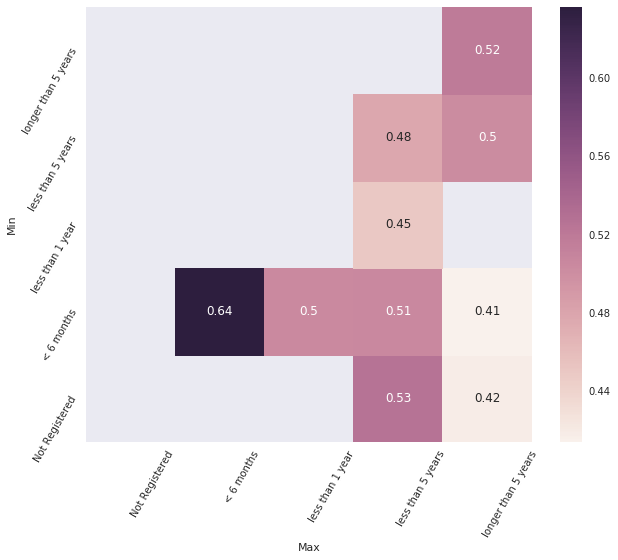

[[23, 23, 15, 82, 19], [0, 105, 67, 192, 30], [0, 1, 106, 135, 14], [5, 1, 1, 740, 122], [2, 1, 0, 0, 284]]


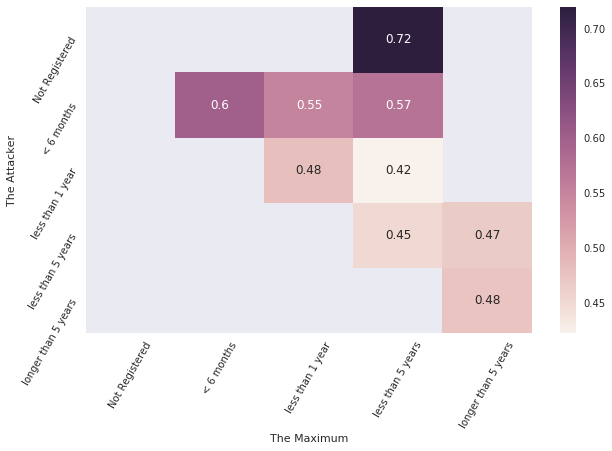

dict_keys([0, 2, -1])
[ 0.44200627  0.42570281  0.48753894  0.55847953  0.56009615]
[0.02790527857733463, 0.031916216010642505, 0.019967363475856741, 0.026916457146751741, 0.024108604274505792]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [319, 249, 642, 342, 416]
[ 0.44200627  0.42570281  0.48753894  0.55847953  0.56009615]


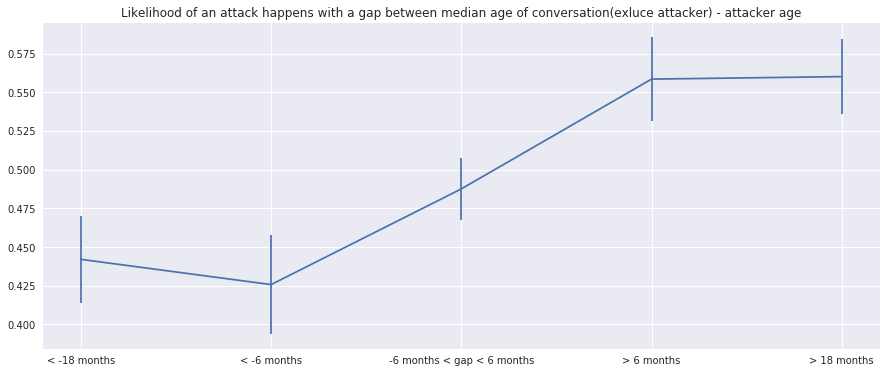

((-0.20171067181949992, 1.6301427602322248e-19),)

In [45]:
aspect = 'age'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 6, 12, 60, 180]
tile_legends = ['Not Registered', '< 6 months', 'less than 1 year', 'less than 5 years', 'longer than 5 years']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [6, 18])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap ,['< -18 months', '< -6 months', '-6 months < gap < 6 months', '> 6 months', '> 18 months'], aspect)
pearsonr(gaplst, labellst), 

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


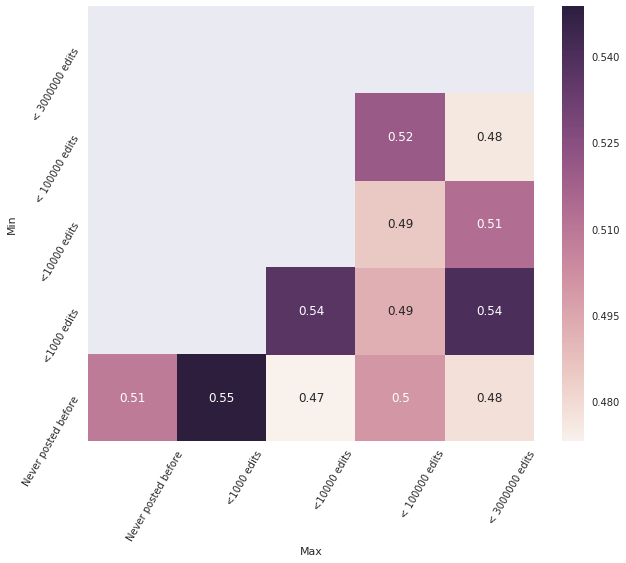

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[226, 61, 93, 147, 66], [0, 70, 37, 74, 46], [0, 0, 151, 139, 76], [0, 0, 0, 433, 125], [0, 0, 0, 0, 224]]


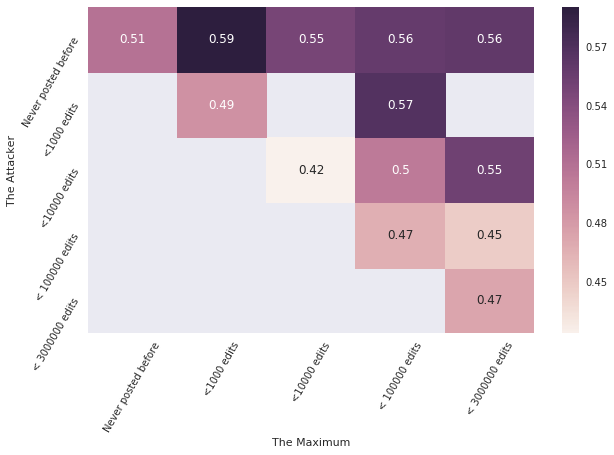

dict_keys([4, 5, 0, 3, 2])
[ 0.46774194  0.44325482  0.48387097  0.54633205  0.54314721]
[0.02795323208831391, 0.022927369954226937, 0.029988537482930094, 0.022099206654998729, 0.025465427016850867]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [310, 467, 279, 518, 394]
[ 0.46774194  0.44325482  0.48387097  0.54633205  0.54314721]


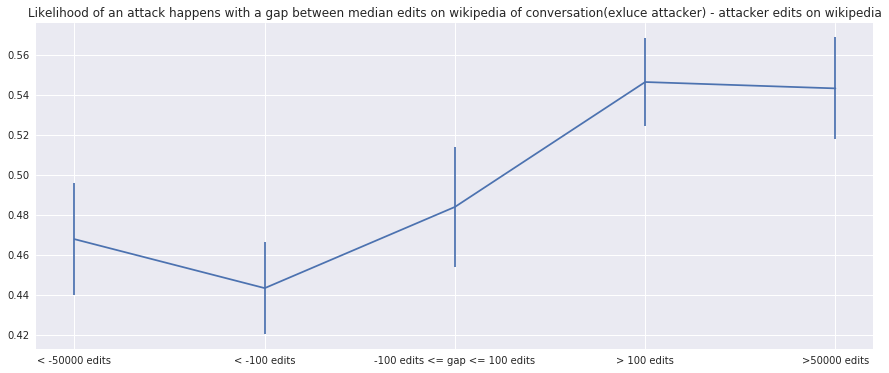

(-0.20171067181949992, 1.6301427602322248e-19)

In [46]:
aspect = 'edits_on_wikipedia_articles'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 1000, 10000, 100000, 3000000]
tile_legends = ['Never posted before', '<1000 edits', '<10000 edits', '< 100000 edits', '< 3000000 edits']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [100, 50000])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap , ['< -50000 edits', '< -100 edits', '-100 edits <= gap <= 100 edits', '> 100 edits', '>50000 edits'], 'edits on wikipedia')
pearsonr(gaplst, labellst)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


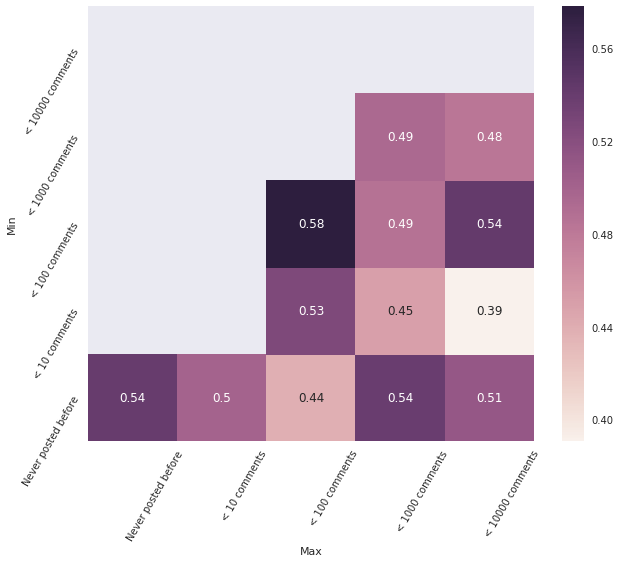

/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yiqing/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[218, 48, 110, 162, 48], [0, 58, 29, 64, 36], [0, 0, 162, 154, 64], [0, 0, 0, 460, 126], [0, 0, 0, 0, 229]]


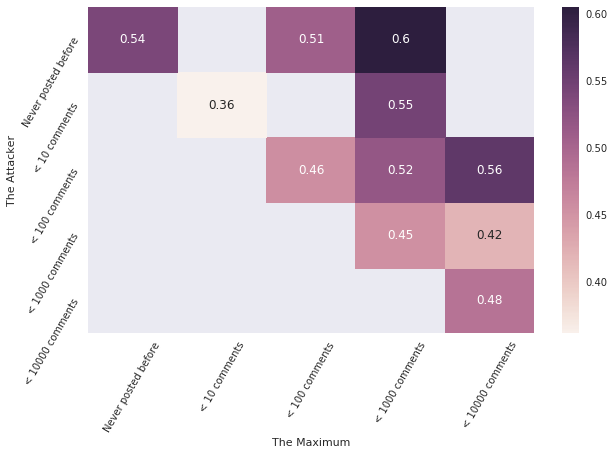

dict_keys([2, 3, 0, 4])
[ 0.5         0.43807339  0.50518135  0.53962264  0.51162791]
[0.029978003172323322, 0.024652920123696669, 0.025341246812945726, 0.022104472484300197, 0.026229732028360687]
[-2, -1, 0, 1, 2]
Number of conversations in the group: [272, 436, 386, 530, 344]
[ 0.5         0.43807339  0.50518135  0.53962264  0.51162791]


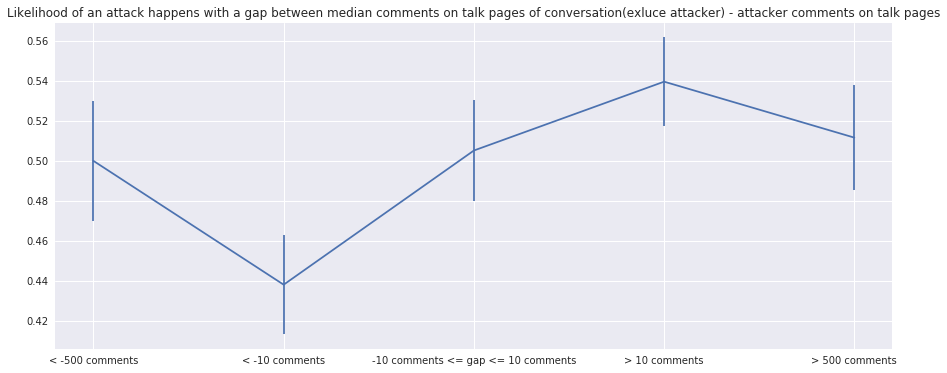

(-0.20171067181949992, 1.6301427602322248e-19)

In [47]:
aspect = 'comments_on_all_talk_pages'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 10 comments', '< 100 comments', '< 1000 comments', '< 10000 comments']
#discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
data, gaps, gaplst, labellst = discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker, attacker_gap = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets, [10, 500])
#attacker_plot(the_attacker, tile_legends)
print(gaps.keys())
#attacker_plot_gap(gaps , tile_legends)
attacker_plot_gap(attacker_gap , ['< -500 comments', '< -10 comments', '-10 comments <= gap <= 10 comments', '> 10 comments', '> 500 comments'], 'comments on talk pages')
pearsonr(gaplst, labellst)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


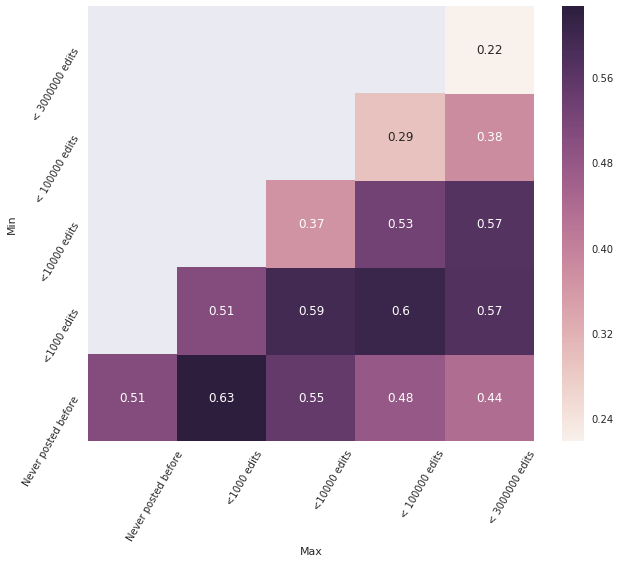

[[2491, 835, 882, 1385, 852], [0, 835, 344, 696, 453], [0, 0, 979, 592, 507], [0, 0, 0, 2125, 594], [0, 0, 0, 0, 1238]]


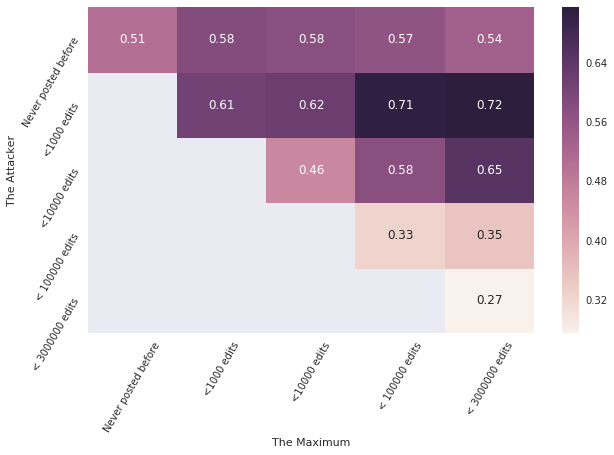

Number of conversations in the group: [6445, 2328, 2078, 2719, 1238]


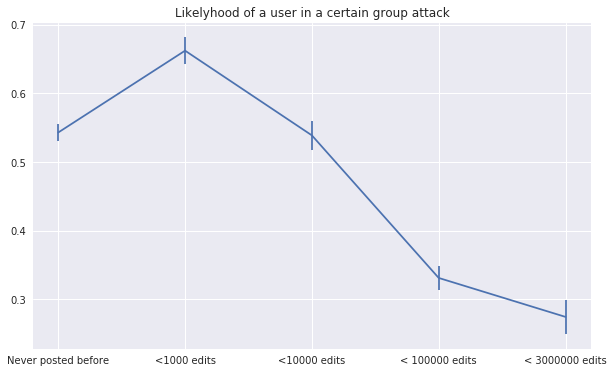

In [66]:
aspect = 'edits_on_wikipedia_articles'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 1000, 10000, 100000, 3000000]
tile_legends = ['Never posted before', '<1000 edits', '<10000 edits', '< 100000 edits', '< 3000000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
the_attacker = propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends, feature_sets)
attacker_plot(the_attacker, tile_legends)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


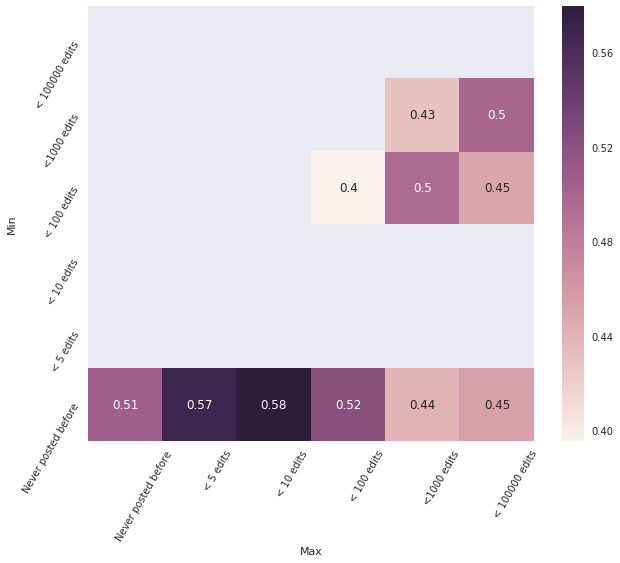

TypeError: propencity_of_attacking() missing 1 required positional argument: 'feature_sets'

In [67]:
aspect = 'edits_on_subjectpage'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 100, 1000, 100000]
tile_legends = ['Never posted before', '< 5 edits', '< 10 edits', '< 100 edits', '<1000 edits', '< 100000 edits']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [ ]:
aspect = 'comments_on_same_talk_page'
v = get_values(aspect, feature_sets)
tiles = [0.000000001, 5, 10, 250]
tile_legends = ['Never posted before', '< 5 comments', '< 10 comments', '> 10 comments']
discrepancy_heatmap(aspect, feature_sets, tiles, tile_legends)
propencity_of_attacking(aspect, user_infos, documents, tiles, tile_legends)

In [202]:
print(min(v),max(v), np.percentile(v, 25), np.percentile(v, 50), np.percentile(v, 75))

0 2450371 0.0 7364.0 55164.0


In [67]:
ASPECTS

['age',
 'status',
 'comments_on_same_talk_page',
 'comments_on_all_talk_pages',
 'edits_on_subjectpage',
 'edits_on_wikipedia_articles']

In [64]:
tiles

[0.0,
 0.0,
 0.0,
 4.0,
 30.0,
 84.0,
 171.0,
 345.0,
 662.0,
 1465.4000000000015,
 86090.0]

In [69]:
# Need to manually define tiles
aspect = ASPECTS[3]
tiles = discrepancy_heatmap(aspect, feature_sets, 5)
propencity_of_attacking(aspect, user_infos, documents, tiles, 5)

7 5 [0.0, 0.0, 30.0, 171.0, 662.0, 86090.0]


IndexError: list index out of range

# Plots and Examples

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


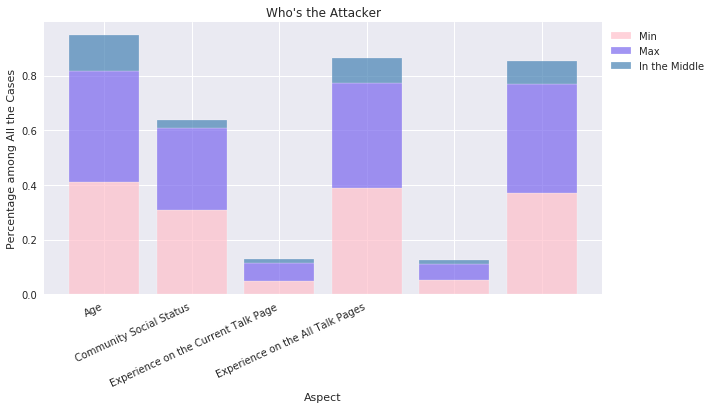

In [93]:
plot_profiles(profiles, 1, ASPECTS)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


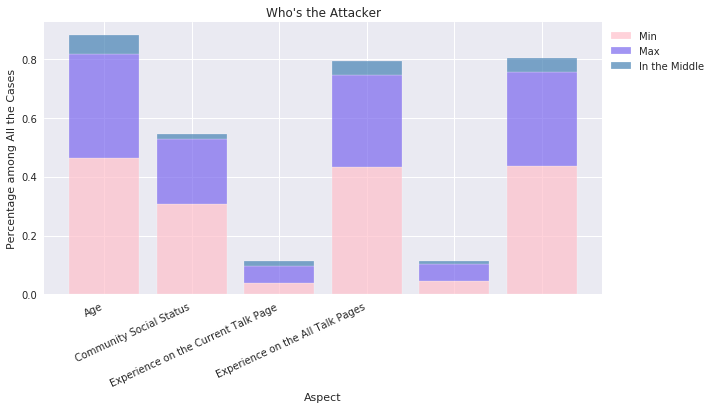

In [94]:
plot_profiles(profiles, 0, ASPECTS)

In [28]:
get_examples(documents, feature_sets, 'has_content_repeat', 1, 1, 1)

== the grim and frostbitten beginning == Here it is. It's mostly kinda minimal for now, since I've copied it all from 's pages and the parent project's pages. I haven't changed the colors yet though. That may be something to do later on. 
Navnløs
-1
ARGH! Grimmig und Erfroren!!!! I love it. I'm surprised we're even allowed to use an upside-down cross as our image thing. 
Navnløs
0
 :I have no idea if we actually are, but it was the first thing that came to my mind. We can change it if we get complaints, but I hope we won't because it's petty awesome.
5theye
1
 ::We can and will. If you get any Christian types complaining, send them towards [WP:CENSORED], and tell them [Cross of St. Peter@that they really need to learn a little about their own religion].
J Milburn
2
It is pretty awesome. J Milburn' is right about wikipedia not being censored and I realize the inverted cross is actually originally a Christian symbol (and still is; though uncommon), but it's obvious we're not using it tha

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


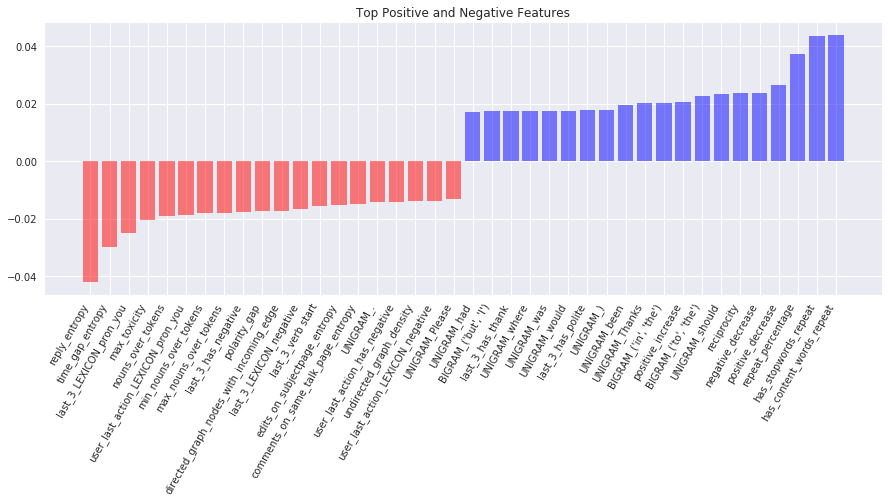

In [46]:
classifier = linear_model.LogisticRegression(C=0.0007)
classifier.fit(X, y)
top_pos, top_neg= plot_coefficients(classifier, feature_names, 20)
#0.630 (+/-0.007) for {'C': 0.0006}

In [44]:
plot_feature_distribution(feature_sets, top_pos)

NameError: name 'plot_feature_distribution' is not defined

finish collecting


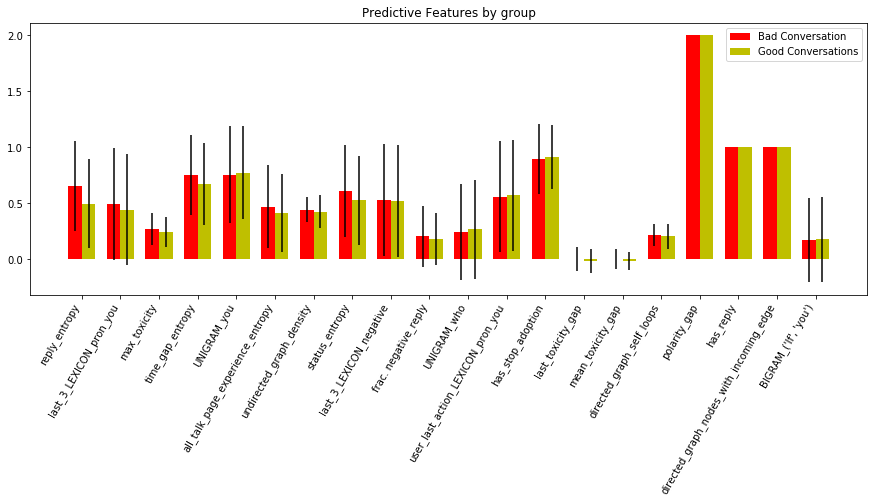

In [178]:
plot_feature_distribution(feature_sets, top_neg)

/home/yiqing/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


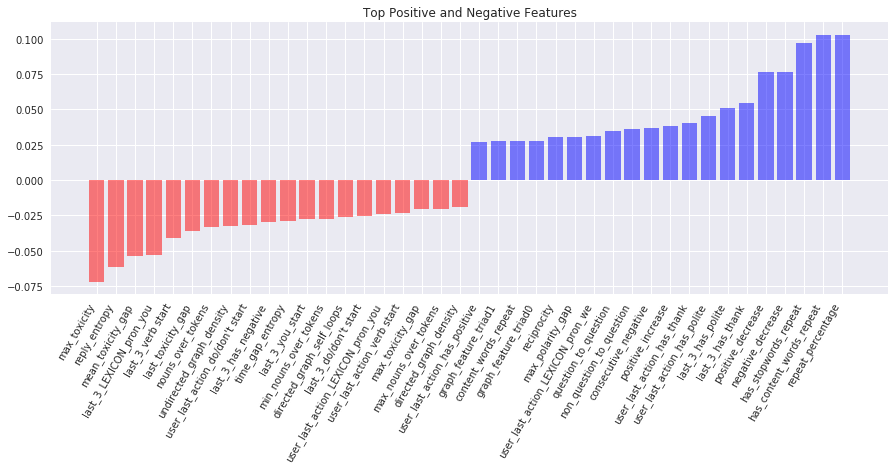

In [26]:
classifier = svm.LinearSVC(C=0.001)
classifier.fit(X, y)
top_pos, top_neg = plot_coefficients(classifier, feature_names, 20)
# bow + action(last 3 actions) + repeat + entropy
# 0.655 (+/-0.007) for {'C': 0.0006}

In [ ]:
# Output Feature Names

In [148]:
negative_features = {c:[] for c in constraints}
positive_features = {c:[] for c in constraints}

In [206]:
negative_features[constraint].append(yy)
positive_features[constraint].append(xx)

In [209]:
for n in negative_features.keys():
    negative_features[n] = negative_features[n][0]

In [210]:
for n in positive_features.keys():
    positive_features[n] = positive_features[n][0]

In [211]:
pd.DataFrame.from_dict(negative_features).to_csv('feature_results_negative.csv', index=False)

In [212]:
pd.DataFrame.from_dict(positive_features).to_csv('feature_results_positive.csv', index=False)

# Spearman Correlation

In [874]:
corr = []
pval = []
names = []
for key in features_corr:
    x,p = spearmanr(number_users, features_corr[key])
    corr.append(x)
    pval.append(p)
    names.append(key)


N = len(corr)

ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

#plt.subplots()
plt.figure(figsize=(15, 5))
plt.bar(ind, corr, width, color='green', alpha=0.5, yerr=pval)

# add some text for labels, title and axes ticks
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation between graph features and number of users')
plt.xticks(ind, names, rotation=60, ha='right')
#ax.set_xticklabels(names)

plt.show()